In [1]:
from ioos_qc.config import QcConfig
from ioos_qc import qartod
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime

from bokeh.layouts import gridplot
from bokeh.plotting import figure, show, output_notebook, save
from bokeh.embed import file_html
from bokeh.resources import CDN
from bokeh.io import output_file, show
output_notebook()

Loading BokehJS ...

In [60]:
def plot_results(data, var_name, results, title, test_name, save_name=None):
    '''
    Basic plot helper function. From Axiom documentation example
    '''
    time = data['dateTime']
    obs = data[var_name]
    qc_test = results['qartod'][test_name]

    qc_pass = np.ma.masked_where(qc_test != 1, obs)
    qc_suspect = np.ma.masked_where(qc_test != 3, obs)
    qc_fail = np.ma.masked_where(qc_test != 4, obs)
    qc_notrun = np.ma.masked_where(qc_test != 2, obs)

    p1 = figure(x_axis_type="datetime", title=test_name + ' : ' + title)
    p1.grid.grid_line_alpha=0.3
    p1.xaxis.axis_label = 'Time'
    p1.yaxis.axis_label = 'Observation Value'

    p1.line(time, obs,  legend='obs', color='#A6CEE3')
    p1.circle(time, qc_notrun, size=2, legend='qc not run', color='gray', alpha=0.2)
    p1.circle(time, qc_pass, size=4, legend='qc pass', color='green', alpha=0.5)
    p1.circle(time, qc_suspect, size=4, legend='qc suspect', color='orange', alpha=0.7)
    p1.circle(time, qc_fail, size=6, legend='qc fail', color='red', alpha=1.0)
            
    show(gridplot([[p1]], plot_width=800, plot_height=400))

    
def make_dataframe(xr_dataset):
    '''
    Return a pandas dataframe of all of the data, indexed by time.
    This only works for single depth and location data
    '''
    data = {}
    for var in xr_dataset.variables:
        if var not in ['TIME','DEPTH','LATITUDE','LONGITUDE']:
            data[var] = xr_dataset[var].to_pandas()
    return pd.DataFrame(data, index=xr_dataset['TIME'].to_pandas())

Note: The convention for naming a generic pandas dataframe is df, I would also avoid just appending names with an incrementing number and use a more qualitative descriptor

In [9]:
#ocsd_data_file = 'C:\Users\bposson\Documents\bposson\csv\temp.csv'
# d1 = pd.read_csv(r'\\atlas\Diatom\socal moorings\deployment_data\20151027\csv\temp.csv') 
# d2 = pd.read_csv(r'\\atlas\Diatom\socal moorings\deployment_data\20161025\csv\temp.csv') 
# d3 = pd.read_csv(r'\\atlas\Diatom\socal moorings\deployment_data\20170628\realTime\temp.csv') 

The headers are not consistent between files, so it would be helpful to rename them.

In [30]:
column_names = ['unix_time_ms','wtempC_5m','wtempC_35m','wtempC_60m']

df_deployment_2015 = pd.read_csv('../data/OCSD_csv_files/temp.csv',names=column_names, skiprows=1) # Skiprows tell pandas to ignore the first line (old headers)
df_deployment_2016 = pd.read_csv('../data/OCSD_csv_files/temp 2.csv',names=column_names, skiprows=1)
df_deployment_2017 = pd.read_csv('../data/OCSD_csv_files/temp 3.csv',names=column_names, skiprows=1)

In [32]:
df_deployment_2015.head()

unix_time_ms  wtempC_5m  wtempC_35m  wtempC_60m
0  1446055200000     22.528      17.306      15.053
1  1446058800000     22.571      17.859      15.447
2  1446062400000     22.606         NaN      15.201
3  1446066000000     22.596      17.667      14.812
4  1446069600000     22.608      17.684      14.745

Converting to a python dateTime object from unix time is straight foreward, the only thing you really need to know is if the units are in seconds, milliseconds, or nanoseconds. It looks like the data here are in miliseconds.

In [37]:
df_deployment_2015['dateTime'] = pd.to_datetime(df_deployment_2015['unix_time_ms'],unit='ms') # converts to dateTime object
df_deployment_2015.index = df_deployment_2015['dateTime'] # Converts to 
df_deployment_2016['dateTime'] = pd.to_datetime(df_deployment_2016['unix_time_ms'],unit='ms') # converts to dateTime object
df_deployment_2016.index = df_deployment_2016['dateTime'] # Converts to 
df_deployment_2017['dateTime'] = pd.to_datetime(df_deployment_2017['unix_time_ms'],unit='ms') # converts to dateTime object
df_deployment_2017.index = df_deployment_2017['dateTime'] # Converts to 

Concatenate each of the deployments into a single dataframe

In [41]:
df = pd.concat([df_deployment_2015,df_deployment_2016,df_deployment_2017])
df.head()


#ds['Unix_Time'] = ds.index.astype(np.int64) // 10**9
#ds['time'] = ds.index
#no idea what these do, they're supposed to change Unix to timestamp, but mine didn't...
# d3.head() #it's an array of data, let's see what happens next!

unix_time_ms  wtempC_5m  wtempC_35m  wtempC_60m  \
dateTime                                                                
2015-10-28 18:00:00  1446055200000     22.528      17.306      15.053   
2015-10-28 19:00:00  1446058800000     22.571      17.859      15.447   
2015-10-28 20:00:00  1446062400000     22.606         NaN      15.201   
2015-10-28 21:00:00  1446066000000     22.596      17.667      14.812   
2015-10-28 22:00:00  1446069600000     22.608      17.684      14.745   

                               dateTime  
dateTime                                 
2015-10-28 18:00:00 2015-10-28 18:00:00  
2015-10-28 19:00:00 2015-10-28 19:00:00  
2015-10-28 20:00:00 2015-10-28 20:00:00  
2015-10-28 21:00:00 2015-10-28 21:00:00  
2015-10-28 22:00:00 2015-10-28 22:00:00

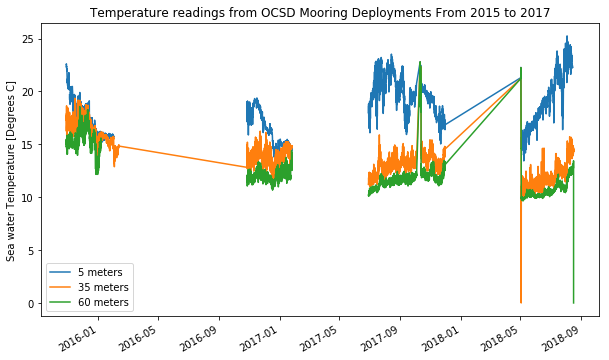

In [53]:
fig, ax = plt.subplots()
fig.set_size_inches(10,6)
ax.plot(df['wtempC_5m'], label='5 meters')
ax.plot(df['wtempC_35m'], label='35 meters')
ax.plot(df['wtempC_60m'], label='60 meters')
ax.legend()
ax.set_ylabel('Sea water Temperature [Degrees C]')
ax.set_title('Temperature readings from OCSD Mooring Deployments From 2015 to 2017');
fig.autofmt_xdate()

In [54]:
df['epoch_time'] = df.index.astype(np.int64) // 10**9

In [57]:
config = {
    'qartod': {
        'gross_range_test': {
            'suspect_span': [12.5, 17.5],
            'fail_span': [10, 20]
        },
        "flat_line_test": {
            "tolerance": 0.01,
            "suspect_threshold": 7200,
            "fail_threshold": 21600
        },
        "rate_of_change_test": {
            "threshold": 0.001
      },
        "spike_test": {
            "suspect_threshold": 0.8,
            "fail_threshold": 3
      }
    }
}


In [58]:
# Add the configuration file to the test object
qc = QcConfig(config)

# Run the test
qc_results =  qc.run(
    inp=df['wtempC_5m'],
    tinp=df['epoch_time']
)
# Aggreate the flags into a single flag
all_tests = [qc_results['qartod'][test_name] for test_name in qc_results['qartod'].keys()]
qc_results['qartod']['qc_agg'] = qartod.qartod_compare(all_tests).astype(int)

In [61]:
#results
title = "Seawater Temp: OCDS"
plot_results(df, 'wtempC_5m', qc_results, title, 'gross_range_test')
plot_results(df, 'wtempC_5m', qc_results, title, 'flat_line_test')
plot_results(df, 'wtempC_5m', qc_results, title, 'spike_test')
plot_results(df, 'wtempC_5m', qc_results, title, 'rate_of_change_test')

In [33]:
#They save the csvs, let's try making the arrays, to start
d1_array = np.array(d1)
d2_array = np.array(d2)
d3_array = np.array(d3)
#arrays made effectively 
#Unix_time = np.concatenate((d1_array[:,0],d2_array[:,0],d3_array[:,0]),axis = None) #save one col at a time
#print(Unix_time)
Temp_5m = np.concatenate((d1_array[:,1],d2_array[:,1],d3_array[:,1]),axis = None) 
Temp_35m = np.concatenate((d1_array[:,2],d2_array[:,2],d3_array[:,2]),axis = None) 
Temp_60m = np.concatenate((d1_array[:,3],d2_array[:,3],d3_array[:,3]),axis = None) 

[1.44605520e+12 1.44605880e+12 1.44606240e+12 ... 1.53438853e+12
 1.53439213e+12 1.53439573e+12]


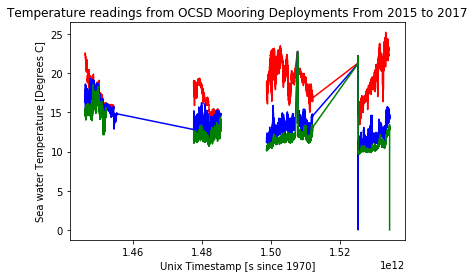

<Figure size 960x720 with 0 Axes>

In [34]:
#Now let's generate the prelim plots
plt.plot(Unix_time,Temp_5m,'r',Unix_time,Temp_35m,'b',Unix_time,Temp_60m,'g')
plt.xlabel('Unix Timestamp [s since 1970]')
plt.ylabel('Sea water Temperature [Degrees C]')
plt.title('Temperature readings from OCSD Mooring Deployments From 2015 to 2017')
plt.figure(num=None, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
plt.show()
#plt.legend('5m deep','35m deep','60m deep')